# Multiomics integration

![title](img/6ae.png)

Here we will use dual-omics 10X PBMCs dataset [link](https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_granulocyte_sorted_10k) as an example to illustrate how SIMBA performs multiomics integration analysis.

In [1]:
import os
import simba as si
si.__version__

'1.1'

In [2]:
workdir = 'multiome_10xpmbc10k_integration'
si.settings.set_workdir(workdir)

Saving results in: multiome_10xpmbc10k_integration


In [3]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

In [4]:
# to make plots prettier
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/tmp/ipykernel_180444/3381039072.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


### load example data

In [5]:
dict_adata = si.datasets.multiome_10xpbmc10k()

multiome_10xpbmc10k_rna.h5ad: 192MB [02:02, 1.56MB/s]                               


Downloaded to multiome_10xpmbc10k_integration/data.


multiome_10xpbmc10k_atac.h5ad: 700MB [07:48, 1.49MB/s]                               


Downloaded to multiome_10xpmbc10k_integration/data.


In [6]:
dict_adata

{'rna': AnnData object with n_obs × n_vars = 11909 × 36601
     obs: 'celltype'
     var: 'gene_ids', 'feature_types', 'genome',
 'atac': AnnData object with n_obs × n_vars = 11909 × 108377
     obs: 'celltype'
     var: 'gene_ids', 'feature_types', 'genome', 'chr', 'start', 'end'}

In the following cell, we manually split cells into cells of RNAseq and ATACseq. This should be omitted in the integration with user data. Data can be loaded as in [API description](https://simba-bio.readthedocs.io/en/latest/API.html#reading): <br>
<pre><code> adata_CX = si.read_10x_h5('your/data/path.h5') </code></pre>

In [7]:
adata_CP = dict_adata['atac']
adata_CG = dict_adata['rna']
# manually split cells into RNAseq cells and ATACseq cells
adata_CP.obs.index = adata_CP.obs.index + '_atac'
adata_CG.obs.index = adata_CG.obs.index + '_rna'

In [9]:
adata_CP.obs.head()

,celltype
AAACAGCCAAGGAATC-1_atac,6
AAACAGCCAATCCCTT-1_atac,15
AAACAGCCAATGCGCT-1_atac,6
AAACAGCCACACTAAT-1_atac,1
AAACAGCCACCAACCG-1_atac,1


In [10]:
adata_CG.obs.head()

,celltype
AAACAGCCAAGGAATC-1_rna,6
AAACAGCCAATCCCTT-1_rna,15
AAACAGCCAATGCGCT-1_rna,6
AAACAGCCACACTAAT-1_rna,1
AAACAGCCACCAACCG-1_rna,1


## ATAC-seq part

### preprocessing

In [11]:
si.pp.filter_peaks(adata_CP,min_n_cells=3)

Before filtering: 
11909 cells, 108377 peaks
Filter peaks based on min_n_cells
After filtering out low-expressed peaks: 
11909 cells, 107385 peaks


In [12]:
si.pp.cal_qc_atac(adata_CP)

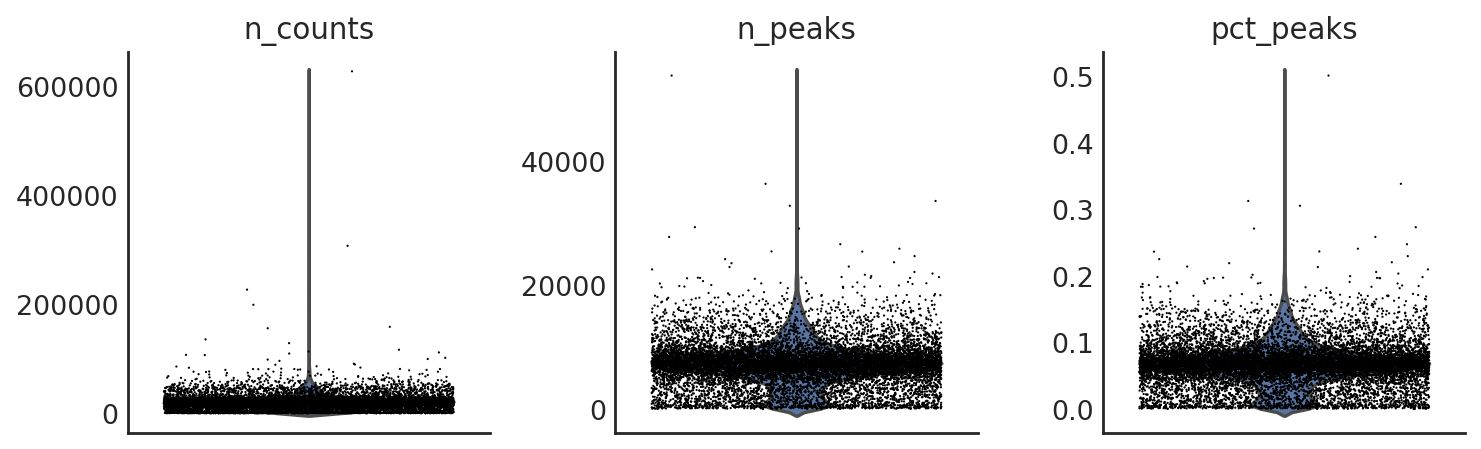

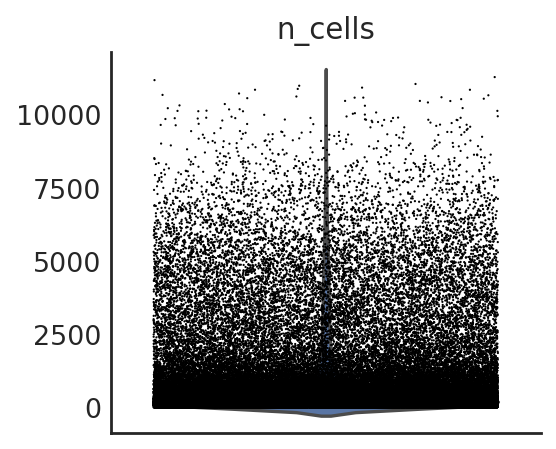

In [13]:
si.pl.violin(adata_CP,list_obs=['n_counts','n_peaks','pct_peaks'], list_var=['n_cells'])

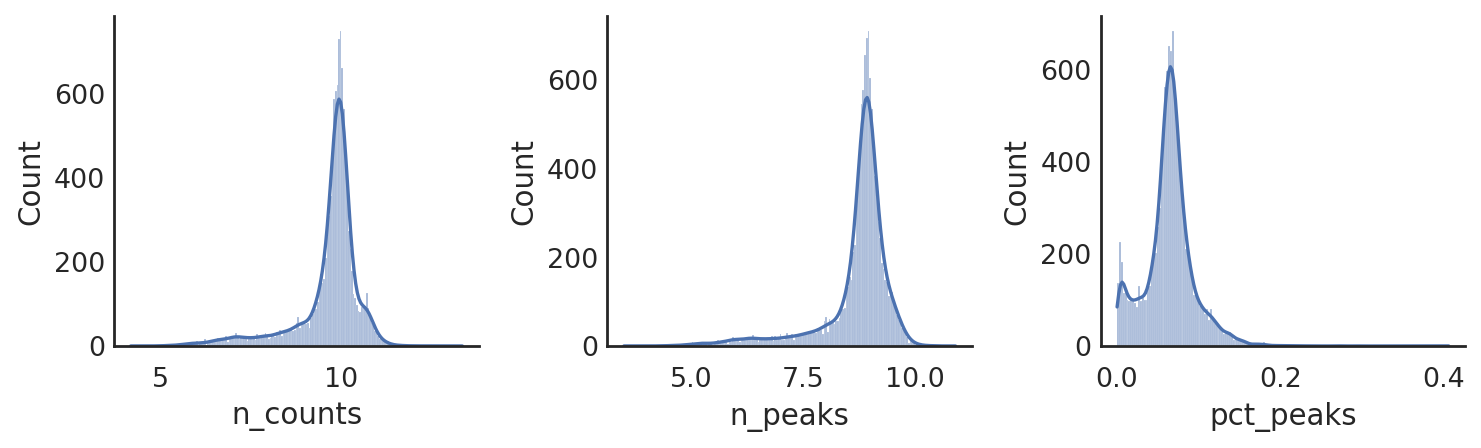

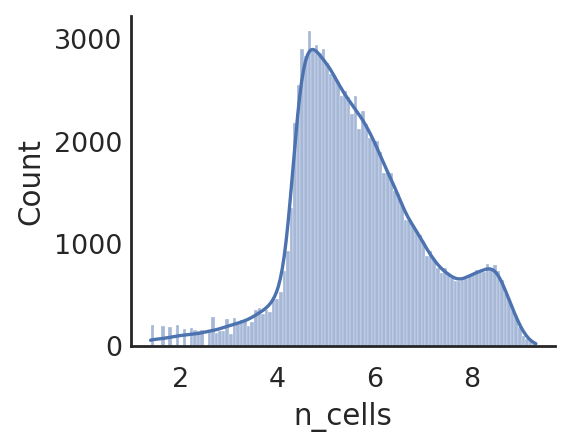

In [14]:
si.pl.hist(adata_CP,list_obs=['n_counts','n_peaks','pct_peaks'], log=True, list_var=['n_cells'])

Filter out cells if needed:

```python
si.pp.filter_cells_atac(adata_CP,min_n_peaks=100)
```

### select peaks (optional)

It will speed up the trainning process by only keeping peaks associated with top PCs

In [15]:
si.pp.pca(adata_CP, n_components=50)

the number of selected PC is: 50


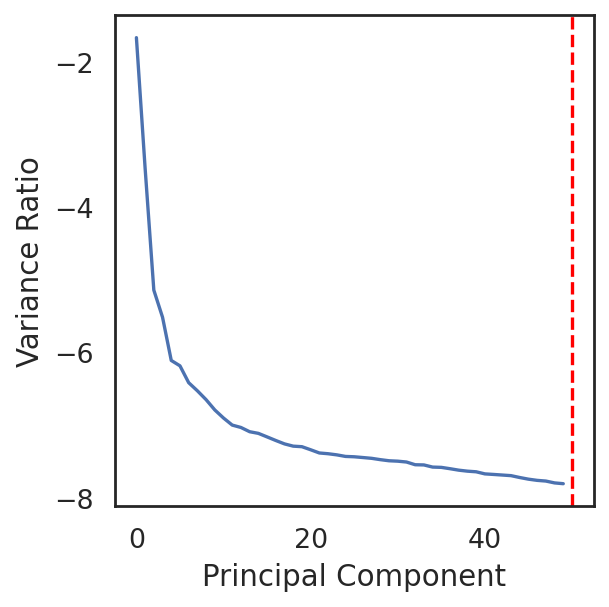

In [16]:
si.pl.pca_variance_ratio(adata_CP)

In [17]:
#The number of selected PCs can be further reduced based on the elbow plot
si.pp.select_pcs(adata_CP,n_pcs=40)

In [18]:
si.pp.select_pcs_features(adata_CP)

#features selected from PC 0: 18006
#features selected from PC 1: 17932
#features selected from PC 2: 17967
#features selected from PC 3: 17927
#features selected from PC 4: 18009
#features selected from PC 5: 17933
#features selected from PC 6: 17903
#features selected from PC 7: 17954
#features selected from PC 8: 17915
#features selected from PC 9: 17935
#features selected from PC 10: 17938
#features selected from PC 11: 17964
#features selected from PC 12: 17936
#features selected from PC 13: 17903
#features selected from PC 14: 17909
#features selected from PC 15: 17947
#features selected from PC 16: 17900
#features selected from PC 17: 17932
#features selected from PC 18: 18012
#features selected from PC 19: 17904
#features selected from PC 20: 17897
#features selected from PC 21: 17967
#features selected from PC 22: 17925
#features selected from PC 23: 17905
#features selected from PC 24: 17927
#features selected from PC 25: 17916
#features selected from PC 26: 17948
#features s

In [19]:
# si.pl.pcs_features(adata_CP, fig_size=(3,3))

## RNA-seq part

### preprocessing

In [20]:
si.pp.filter_genes(adata_CG,min_n_cells=3)

Before filtering: 
11909 cells, 36601 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
11909 cells, 26349 genes


In [21]:
si.pp.cal_qc_rna(adata_CG)

In [22]:
si.pp.normalize(adata_CG,method='lib_size')

In [23]:
si.pp.log_transform(adata_CG)

In [24]:
si.pp.select_variable_genes(adata_CG, n_top_genes=4000)

4000 variable genes are selected.


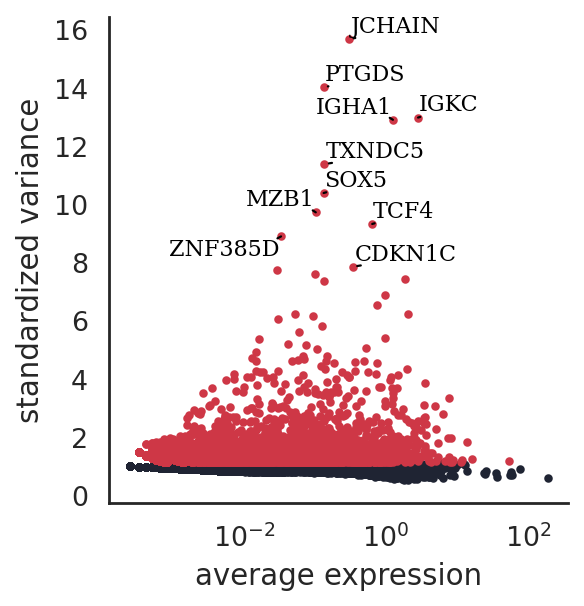

In [25]:
si.pl.variable_genes(adata_CG,show_texts=True)

### discretize RNA expression

In [26]:
si.tl.discretize(adata_CG,n_bins=5)

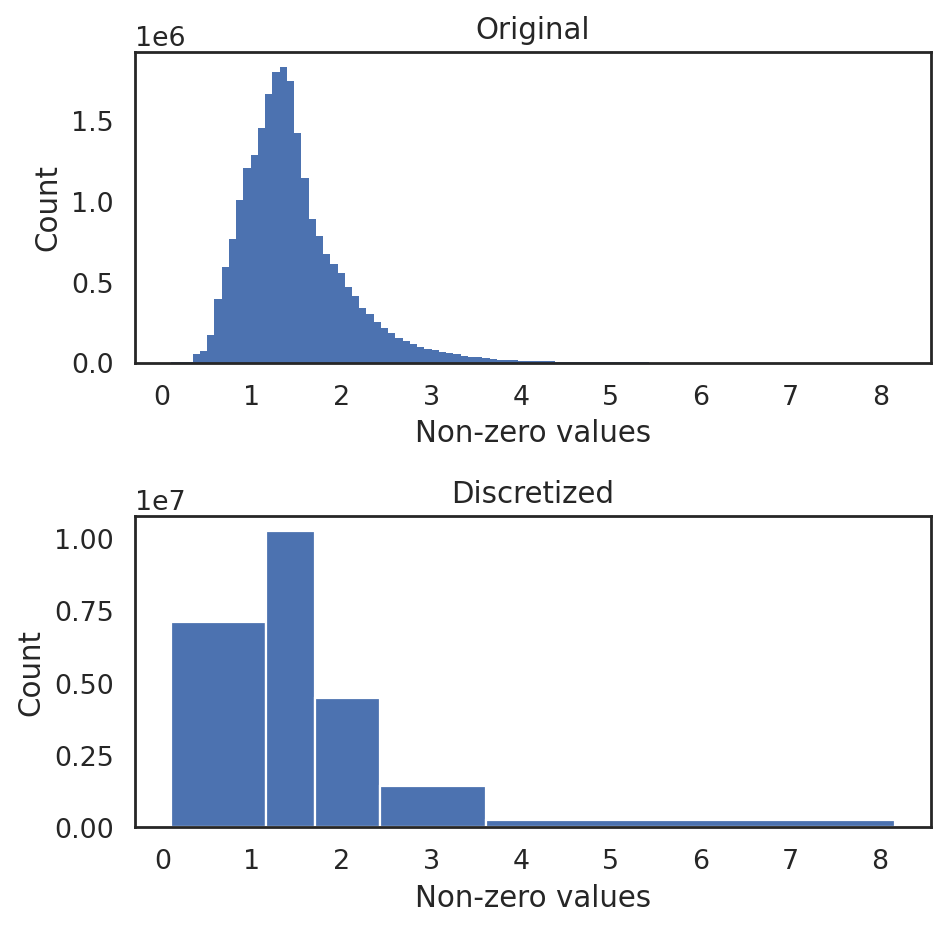

In [27]:
si.pl.discretize(adata_CG,kde=False)

### Infer edges between cells of different modalities

To connect two modalities in the graph, we will infer the edges between RNA cells (batch 1 in the figure) and ATAC cells (batch 2 in the figure).

<img src="img/6_infer_edge.png" alt="Drawing" style="width: 300px;"/>

In [29]:
%%time
adata_CG_atac = si.tl.gene_scores(adata_CP,genome='hg38',use_gene_weigt=True, use_top_pcs=True)

Gene scores are being calculated for the first time
`use_precomputed` has been ignored


***** WARNING: File /tmp/pybedtools.au4c9wzf.tmp has inconsistent naming convention for record:
GL000194.1	101218	101619	61173

***** WARNING: File /tmp/pybedtools.au4c9wzf.tmp has inconsistent naming convention for record:
GL000194.1	101218	101619	61173

***** WARNING: File /tmp/pybedtools.au4c9wzf.tmp has inconsistent naming convention for record:
GL000194.1	101218	101619	61173

***** WARNING: File /tmp/pybedtools.au4c9wzf.tmp has inconsistent naming convention for record:
GL000194.1	101218	101619	61173



Processing: 0.0%
Processing: 20.0%
Processing: 40.0%
Processing: 60.0%
CPU times: user 10min 36s, sys: 3.51 s, total: 10min 39s
Wall time: 10min 39s


In [30]:
si.pp.filter_genes(adata_CG_atac,min_n_cells=3)
si.pp.cal_qc_rna(adata_CG_atac)
si.pp.normalize(adata_CG_atac,method='lib_size')
si.pp.log_transform(adata_CG_atac)

Before filtering: 
11909 cells, 38824 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
11909 cells, 22786 genes


In [31]:
adata_CrnaCatac = si.tl.infer_edges(adata_CG, adata_CG_atac, n_components=15, k=15)

#shared features: 2713
Performing randomized SVD ...
Searching for mutual nearest neighbors ...
89680 edges are selected


In [32]:
adata_CrnaCatac

AnnData object with n_obs × n_vars = 11909 × 11909
    obs: 'celltype', 'n_counts', 'n_genes', 'pct_genes', 'pct_mt'
    var: 'celltype', 'n_counts', 'n_peaks', 'pct_peaks', 'n_genes', 'pct_genes', 'pct_mt'
    obsm: 'svd'
    varm: 'svd'
    layers: 'conn'

#selected edges: 89680


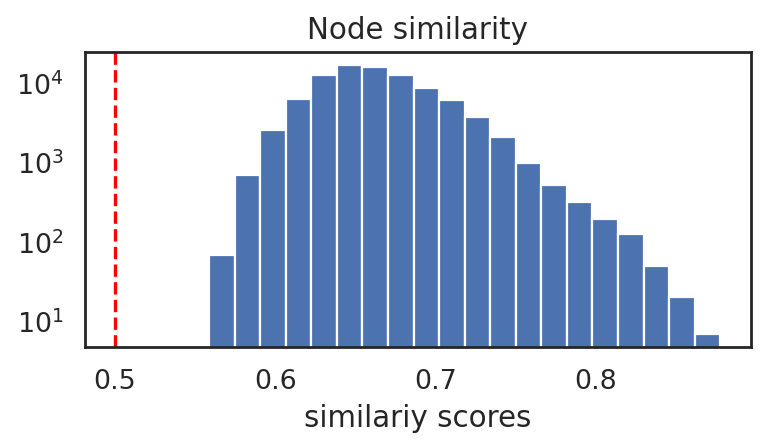

In [87]:
si.pl.node_similarity(adata_CrnaCatac,cutoff=0.5)

In [35]:
# edges can be futhere trimmed if needed. Here we keep all of them
si.tl.trim_edges(adata_CrnaCatac, cutoff=0.5)

89680 edges are selected


### generate Graph

![](img/6_gengraphe.png)

In [36]:
%%time
si.tl.gen_graph(list_CP=[adata_CP],
                list_CG=[adata_CG],
                list_CC=[adata_CrnaCatac],
                copy=False,
                use_highly_variable=True,
                use_top_pcs=True,
                dirname='graph0')

relation0: source: C, destination: P
#edges: 79782752
relation1: source: C2, destination: G
#edges: 1018358
relation2: source: C2, destination: G
#edges: 1566142
relation3: source: C2, destination: G
#edges: 976198
relation4: source: C2, destination: G
#edges: 451109
relation5: source: C2, destination: G
#edges: 61851
relation6: source: C2, destination: C
#edges: 89680
Total number of edges: 83946090
Writing graph file "pbg_graph.txt" to "multiome_10xpmbc10k_integration/pbg/graph0" ...
Finished.
CPU times: user 2min 17s, sys: 27.9 s, total: 2min 44s
Wall time: 2min 47s


### PBG training

![](img/6_embed1.png)

Before PBG training, let’s take a look at the parameters:

In [37]:
si.settings.pbg_params

{'entity_path': 'multiome_10xpmbc10k_integration/pbg/graph0/input/entity',
 'edge_paths': ['multiome_10xpmbc10k_integration/pbg/graph0/input/edge'],
 'checkpoint_path': '',
 'entities': {'C': {'num_partitions': 1},
  'C2': {'num_partitions': 1},
  'G': {'num_partitions': 1},
  'P': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'P',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'C2', 'rhs': 'G', 'operator': 'none', 'weight': 1.0},
  {'name': 'r2', 'lhs': 'C2', 'rhs': 'G', 'operator': 'none', 'weight': 2.0},
  {'name': 'r3', 'lhs': 'C2', 'rhs': 'G', 'operator': 'none', 'weight': 3.0},
  {'name': 'r4', 'lhs': 'C2', 'rhs': 'G', 'operator': 'none', 'weight': 4.0},
  {'name': 'r5', 'lhs': 'C2', 'rhs': 'G', 'operator': 'none', 'weight': 5.0},
  {'name': 'r6', 'lhs': 'C2', 'rhs': 'C', 'operator': 'none', 'weight': 10.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers':

If no parameters need to be adjusted, the training can be simply done with:

```python
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')
```

Here we show how to adjust training-related parameters if needed. In general, weight decay `wd` is the only parameter that might need to be adjusted based on the following pbg metric plots. However, in almost all the cases, the automatically decided `wd` (enabling it by setting `auto_wd=True`) works well.

E.g. we want to change the number of cpus `workers`:

In [38]:
%%time
# modify parameters
dict_config = si.settings.pbg_params.copy()
# dict_config['wd'] = 0.000282
dict_config['workers'] = 12

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model')

Auto-estimated weight decay is 0.000282
`.settings.pbg_params['wd']` has been updated to 0.000282
Converting input data ...
[2021-11-10 00:12:12.212449] Using the 7 relation types given in the config
[2021-11-10 00:12:12.213420] Searching for the entities in the edge files...
[2021-11-10 00:13:51.944837] Entity type C:
[2021-11-10 00:13:51.946211] - Found 11909 entities
[2021-11-10 00:13:51.946561] - Removing the ones with fewer than 1 occurrences...
[2021-11-10 00:13:51.948567] - Left with 11909 entities
[2021-11-10 00:13:51.948843] - Shuffling them...
[2021-11-10 00:13:51.955044] Entity type C2:
[2021-11-10 00:13:51.955308] - Found 11909 entities
[2021-11-10 00:13:51.955569] - Removing the ones with fewer than 1 occurrences...
[2021-11-10 00:13:51.957568] - Left with 11909 entities
[2021-11-10 00:13:51.957833] - Shuffling them...
[2021-11-10 00:13:51.963389] Entity type G:
[2021-11-10 00:13:51.964093] - Found 4000 entities
[2021-11-10 00:13:51.964311] - Removing the ones with fewer t

[2021-11-10 00:14:34.843806] - Processed 9600000 edges so far...
[2021-11-10 00:14:35.315012] - Processed 9700000 edges so far...
[2021-11-10 00:14:35.784773] - Processed 9800000 edges so far...
[2021-11-10 00:14:36.257670] - Processed 9900000 edges so far...
[2021-11-10 00:14:36.762980] - Processed 10000000 edges so far...
[2021-11-10 00:14:37.257723] - Processed 10100000 edges so far...
[2021-11-10 00:14:37.693450] - Processed 10200000 edges so far...
[2021-11-10 00:14:38.123206] - Processed 10300000 edges so far...
[2021-11-10 00:14:38.538123] - Processed 10400000 edges so far...
[2021-11-10 00:14:38.968737] - Processed 10500000 edges so far...
[2021-11-10 00:14:39.401226] - Processed 10600000 edges so far...
[2021-11-10 00:14:39.814883] - Processed 10700000 edges so far...
[2021-11-10 00:14:40.251299] - Processed 10800000 edges so far...
[2021-11-10 00:14:40.671335] - Processed 10900000 edges so far...
[2021-11-10 00:14:41.091985] - Processed 11000000 edges so far...
[2021-11-10 00

[2021-11-10 00:15:28.416398] - Processed 22100000 edges so far...
[2021-11-10 00:15:28.830596] - Processed 22200000 edges so far...
[2021-11-10 00:15:29.268271] - Processed 22300000 edges so far...
[2021-11-10 00:15:29.685794] - Processed 22400000 edges so far...
[2021-11-10 00:15:30.115845] - Processed 22500000 edges so far...
[2021-11-10 00:15:30.548627] - Processed 22600000 edges so far...
[2021-11-10 00:15:30.964748] - Processed 22700000 edges so far...
[2021-11-10 00:15:31.401923] - Processed 22800000 edges so far...
[2021-11-10 00:15:31.816419] - Processed 22900000 edges so far...
[2021-11-10 00:15:32.246394] - Processed 23000000 edges so far...
[2021-11-10 00:15:32.663802] - Processed 23100000 edges so far...
[2021-11-10 00:15:33.082048] - Processed 23200000 edges so far...
[2021-11-10 00:15:33.502399] - Processed 23300000 edges so far...
[2021-11-10 00:15:33.919382] - Processed 23400000 edges so far...
[2021-11-10 00:15:34.337419] - Processed 23500000 edges so far...
[2021-11-1

[2021-11-10 00:16:25.298984] - Processed 34600000 edges so far...
[2021-11-10 00:16:25.783547] - Processed 34700000 edges so far...
[2021-11-10 00:16:26.246626] - Processed 34800000 edges so far...
[2021-11-10 00:16:26.710160] - Processed 34900000 edges so far...
[2021-11-10 00:16:27.177344] - Processed 35000000 edges so far...
[2021-11-10 00:16:27.643001] - Processed 35100000 edges so far...
[2021-11-10 00:16:28.113871] - Processed 35200000 edges so far...
[2021-11-10 00:16:28.576722] - Processed 35300000 edges so far...
[2021-11-10 00:16:29.042963] - Processed 35400000 edges so far...
[2021-11-10 00:16:29.501391] - Processed 35500000 edges so far...
[2021-11-10 00:16:29.995912] - Processed 35600000 edges so far...
[2021-11-10 00:16:30.457380] - Processed 35700000 edges so far...
[2021-11-10 00:16:30.920189] - Processed 35800000 edges so far...
[2021-11-10 00:16:31.379848] - Processed 35900000 edges so far...
[2021-11-10 00:16:31.871285] - Processed 36000000 edges so far...
[2021-11-1

[2021-11-10 00:17:23.530924] - Processed 47100000 edges so far...
[2021-11-10 00:17:23.997961] - Processed 47200000 edges so far...
[2021-11-10 00:17:24.462877] - Processed 47300000 edges so far...
[2021-11-10 00:17:24.927467] - Processed 47400000 edges so far...
[2021-11-10 00:17:25.400969] - Processed 47500000 edges so far...
[2021-11-10 00:17:25.872352] - Processed 47600000 edges so far...
[2021-11-10 00:17:26.337143] - Processed 47700000 edges so far...
[2021-11-10 00:17:26.792167] - Processed 47800000 edges so far...
[2021-11-10 00:17:27.248418] - Processed 47900000 edges so far...
[2021-11-10 00:17:27.707669] - Processed 48000000 edges so far...
[2021-11-10 00:17:28.175978] - Processed 48100000 edges so far...
[2021-11-10 00:17:28.639399] - Processed 48200000 edges so far...
[2021-11-10 00:17:29.105577] - Processed 48300000 edges so far...
[2021-11-10 00:17:29.572781] - Processed 48400000 edges so far...
[2021-11-10 00:17:30.052640] - Processed 48500000 edges so far...
[2021-11-1

[2021-11-10 00:18:23.509749] - Processed 59600000 edges so far...
[2021-11-10 00:18:24.001611] - Processed 59700000 edges so far...
[2021-11-10 00:18:24.490615] - Processed 59800000 edges so far...
[2021-11-10 00:18:24.981876] - Processed 59900000 edges so far...
[2021-11-10 00:18:25.479099] - Processed 60000000 edges so far...
[2021-11-10 00:18:25.953246] - Processed 60100000 edges so far...
[2021-11-10 00:18:26.427487] - Processed 60200000 edges so far...
[2021-11-10 00:18:26.906068] - Processed 60300000 edges so far...
[2021-11-10 00:18:27.382670] - Processed 60400000 edges so far...
[2021-11-10 00:18:27.857597] - Processed 60500000 edges so far...
[2021-11-10 00:18:28.341810] - Processed 60600000 edges so far...
[2021-11-10 00:18:28.816540] - Processed 60700000 edges so far...
[2021-11-10 00:18:29.288159] - Processed 60800000 edges so far...
[2021-11-10 00:18:29.759898] - Processed 60900000 edges so far...
[2021-11-10 00:18:30.235094] - Processed 61000000 edges so far...
[2021-11-1

[2021-11-10 00:19:20.352164] - Processed 72200000 edges so far...
[2021-11-10 00:19:20.767910] - Processed 72300000 edges so far...
[2021-11-10 00:19:21.189767] - Processed 72400000 edges so far...
[2021-11-10 00:19:21.610524] - Processed 72500000 edges so far...
[2021-11-10 00:19:22.027524] - Processed 72600000 edges so far...
[2021-11-10 00:19:22.460212] - Processed 72700000 edges so far...
[2021-11-10 00:19:22.930646] - Processed 72800000 edges so far...
[2021-11-10 00:19:23.343212] - Processed 72900000 edges so far...
[2021-11-10 00:19:23.756167] - Processed 73000000 edges so far...
[2021-11-10 00:19:24.204894] - Processed 73100000 edges so far...
[2021-11-10 00:19:24.619131] - Processed 73200000 edges so far...
[2021-11-10 00:19:25.027301] - Processed 73300000 edges so far...
[2021-11-10 00:19:25.439675] - Processed 73400000 edges so far...
[2021-11-10 00:19:25.887004] - Processed 73500000 edges so far...
[2021-11-10 00:19:26.297051] - Processed 73600000 edges so far...
[2021-11-1

> If `wd` is specified by users instead of being automatically decided, then make sure to update it in simba setting:
```python
si.settings.pbg_params = dict_config.copy()
```

The trained result can be loaded in with the following steps:

By default, it's using the current training result stored in `.setting.pbg_params`
```python
# load in graph ('graph0') info
si.load_graph_stats()
# load in model info for ('graph0')
si.load_pbg_config()
```
Users can also specify different paths.
```python
# load in graph ('graph0') info
si.load_graph_stats(path='./multiome_10xpmbc10k_integration/pbg/graph0/')
# load in model info for ('graph0')
si.load_pbg_config(path='./multiome_10xpmbc10k_integration/pbg/graph0/model/')
```

Plotting training metrics to make sure the model is not overfitting

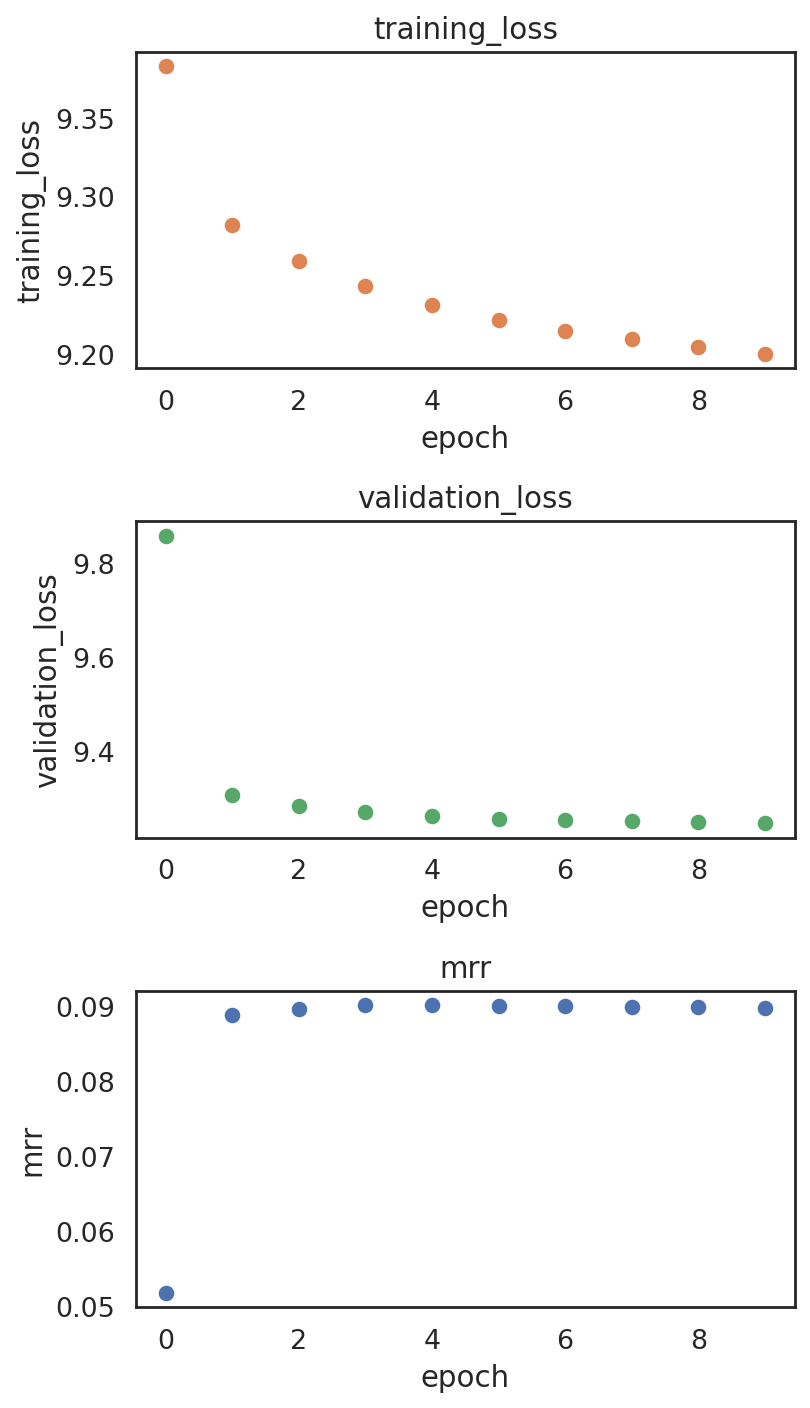

In [39]:
si.pl.pbg_metrics(fig_ncol=1)

## Post-training Analysis

In [40]:
dict_adata = si.read_embedding()

In [41]:
dict_adata

{'G': AnnData object with n_obs × n_vars = 4000 × 50,
 'C2': AnnData object with n_obs × n_vars = 11909 × 50,
 'P': AnnData object with n_obs × n_vars = 61189 × 50,
 'C': AnnData object with n_obs × n_vars = 11909 × 50}

In [42]:
adata_C = dict_adata['C']  # embeddings for ATACseq cells 
adata_C2 = dict_adata['C2']  # embeddings for RNAseq cells
adata_G = dict_adata['G']  # embeddings for genes
adata_P = dict_adata['P']  # embeddings for peaks

In [43]:
adata_C

AnnData object with n_obs × n_vars = 11909 × 50

In [44]:
adata_C2

AnnData object with n_obs × n_vars = 11909 × 50

In [45]:
adata_G

AnnData object with n_obs × n_vars = 4000 × 50

In [46]:
adata_P

AnnData object with n_obs × n_vars = 61189 × 50

In [47]:
adata_CP.obs['celltype'] = adata_CP.obs['celltype'].astype(str)
adata_CG.obs['celltype'] = adata_CG.obs['celltype'].astype(str)

import seaborn as sns
import numpy as np
pal = sns.color_palette('deep', 10).as_hex() + sns.color_palette('pastel', 10).as_hex()
palette_celltype={x:pal[i] for i,x in enumerate(np.arange(1,20).astype(str))}

visualize embeddings of ATAC-seq cells

In [48]:
## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CP[adata_C.obs_names,:].obs['celltype'].copy()
adata_C

AnnData object with n_obs × n_vars = 11909 × 50
    obs: 'celltype'

In [49]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)

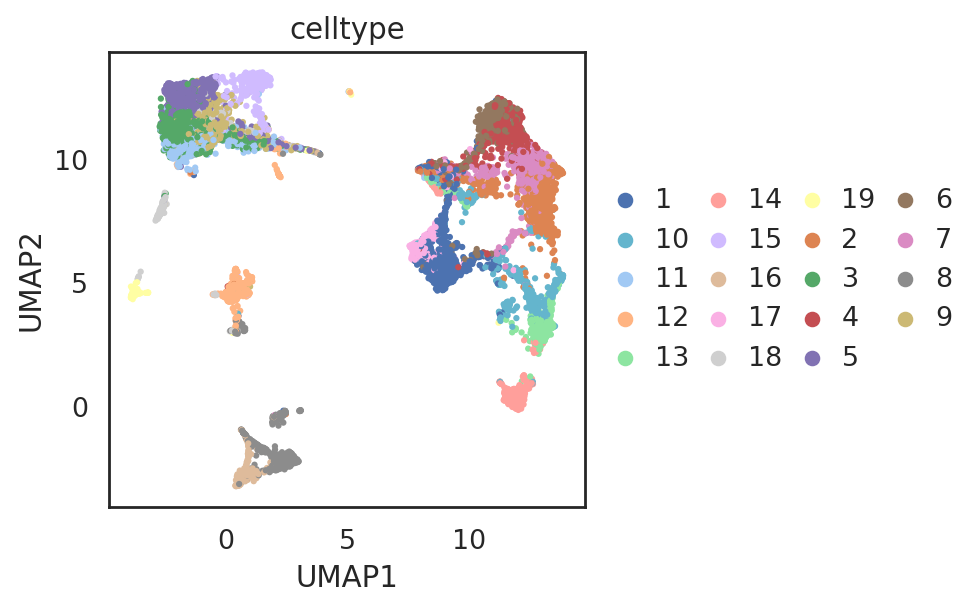

In [50]:
si.pl.umap(adata_C,
           color=['celltype'],
           dict_palette={'celltype': palette_celltype},
           drawing_order='random',
           fig_size=(6,4),
           fig_legend_ncol=4)

visualize embeddings of RNA-seq cells

In [51]:
## Add annotation of celltypes (optional)
adata_C2.obs['celltype'] = adata_CG[adata_C2.obs_names,:].obs['celltype'].copy()
adata_C2

AnnData object with n_obs × n_vars = 11909 × 50
    obs: 'celltype'

In [52]:
si.tl.umap(adata_C2,n_neighbors=15,n_components=2)

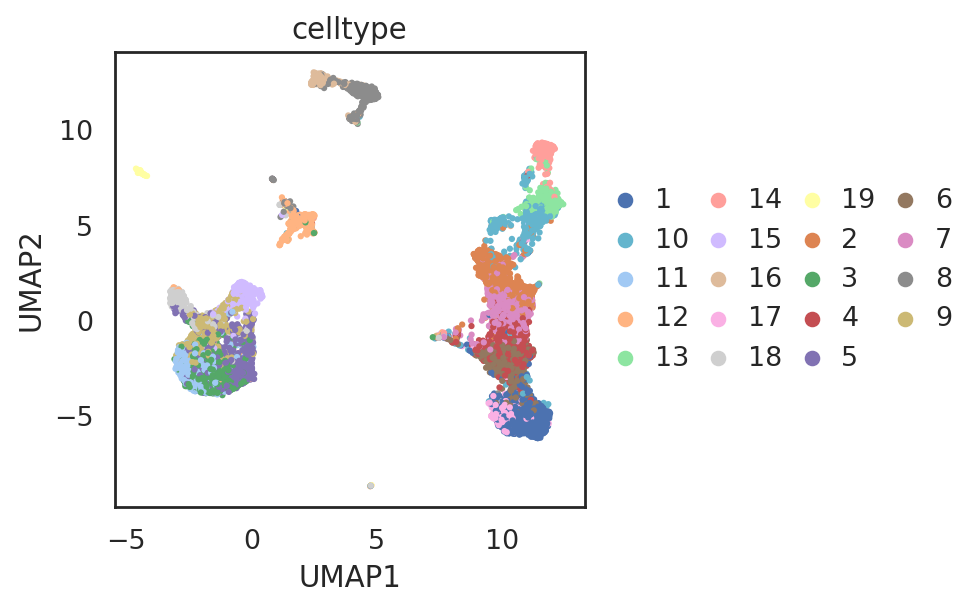

In [53]:
si.pl.umap(adata_C2,
           color=['celltype'],
           dict_palette={'celltype': palette_celltype},
           drawing_order='random',
           fig_size=(6,4),
           fig_legend_ncol=4)

visualize embeddings of both ATACseq cells and RNAseq cells (RNAseq cells are used as the reference)

In [54]:
adata_all = si.tl.embed(adata_ref=adata_C2,
                        list_adata_query=[adata_C],
                        use_precomputed=False)

Performing softmax transformation for query data 0;


In [55]:
## add annotations of cells
adata_all.obs['entity_group'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_group'] = "ATAC-seq"
adata_all.obs.loc[adata_C2.obs_names, 'entity_group'] = "RNA-seq"
adata_all.obs.head()

,celltype,id_dataset,entity_group
TACAATGTCACCTGCT-1_rna,5,ref,RNA-seq
AAGGATGTCGGTAACT-1_rna,4,ref,RNA-seq
TACCTTTAGGATAAAC-1_rna,5,ref,RNA-seq
CCGCTAAAGCAGGCCT-1_rna,4,ref,RNA-seq
CTTGCAACATCATGTG-1_rna,13,ref,RNA-seq


In [56]:
si.tl.umap(adata_all,n_neighbors=15,n_components=2)

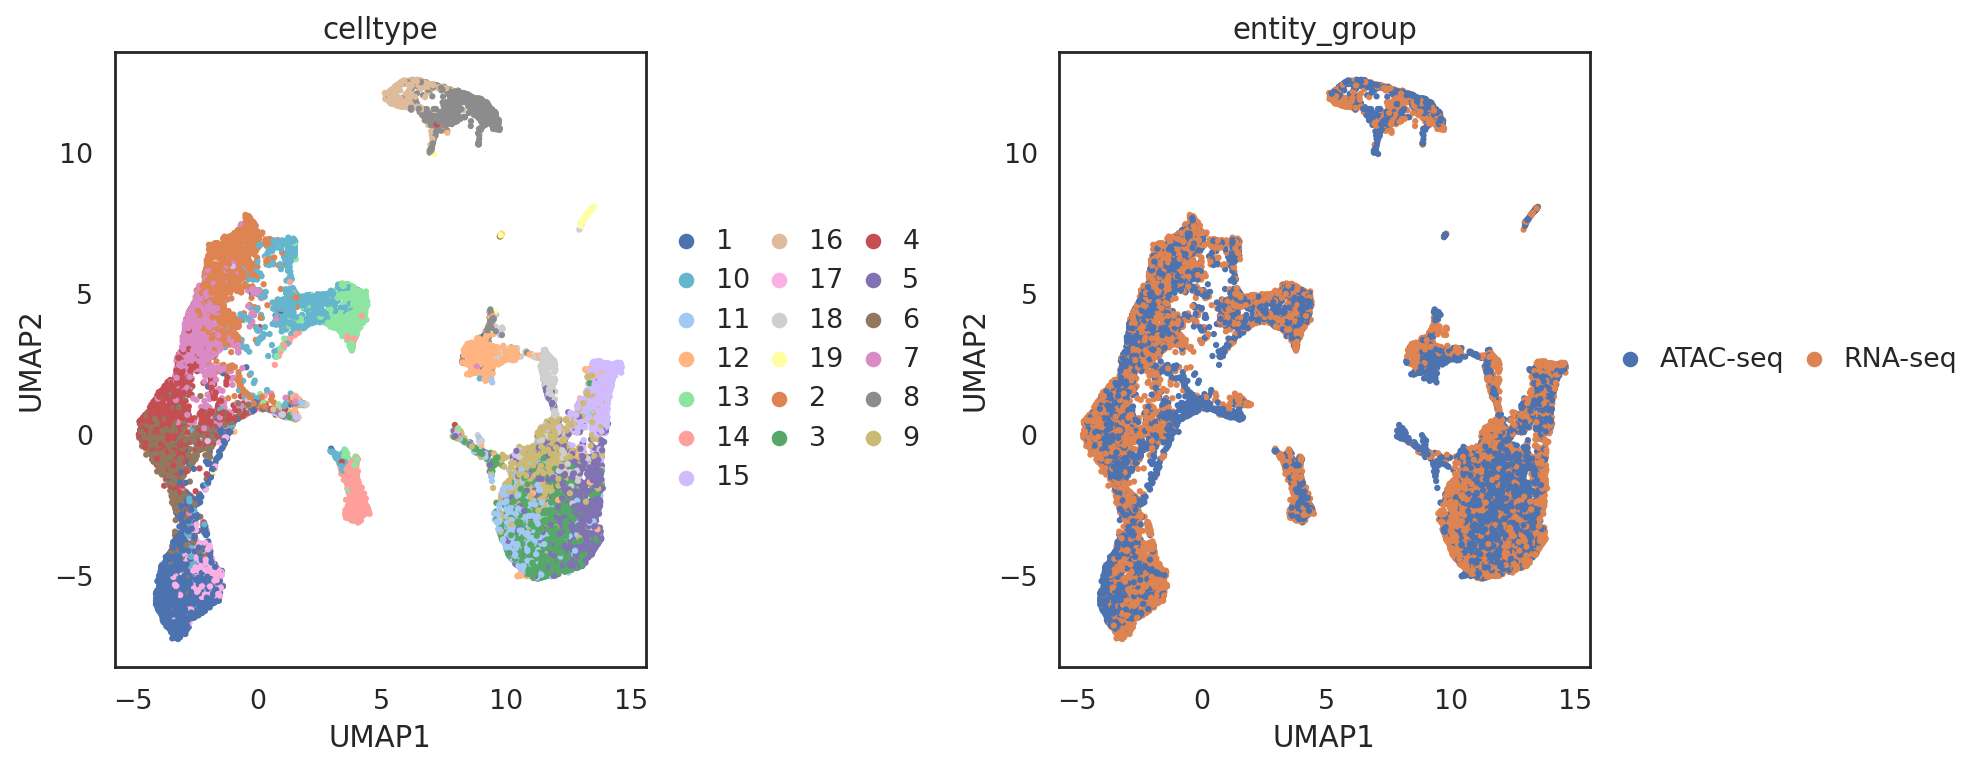

In [57]:
si.pl.umap(adata_all,
           color=['celltype', 'entity_group'],
           dict_palette={'celltype': palette_celltype},
           drawing_order='random',
           fig_size=(6,5),
           fig_legend_ncol=3)

visualize embeddings of both ATACseq cells and RNAseq cells (ATACseq cells are used as the reference)

In [58]:
adata_all2 = si.tl.embed(adata_ref=adata_C,
                        list_adata_query=[adata_C2])

Performing softmax transformation for query data 0;


In [59]:
## add annotations of cells and genes
adata_all2.obs['entity_group'] = ""
adata_all2.obs.loc[adata_C.obs_names, 'entity_group'] = "ATAC-seq"
adata_all2.obs.loc[adata_C2.obs_names, 'entity_group'] = "RNA-seq"
adata_all2.obs.head()

,celltype,id_dataset,entity_group
ATGTCCACAGGACCAA-1_atac,12,ref,ATAC-seq
TAGGAACCATAGCTGC-1_atac,10,ref,ATAC-seq
TAAACAGCAGTAATAG-1_atac,11,ref,ATAC-seq
TTTGCATTCACAAGCT-1_atac,1,ref,ATAC-seq
AGTTGTCAGGCATTAC-1_atac,4,ref,ATAC-seq


In [60]:
si.tl.umap(adata_all2,n_neighbors=15,n_components=2)

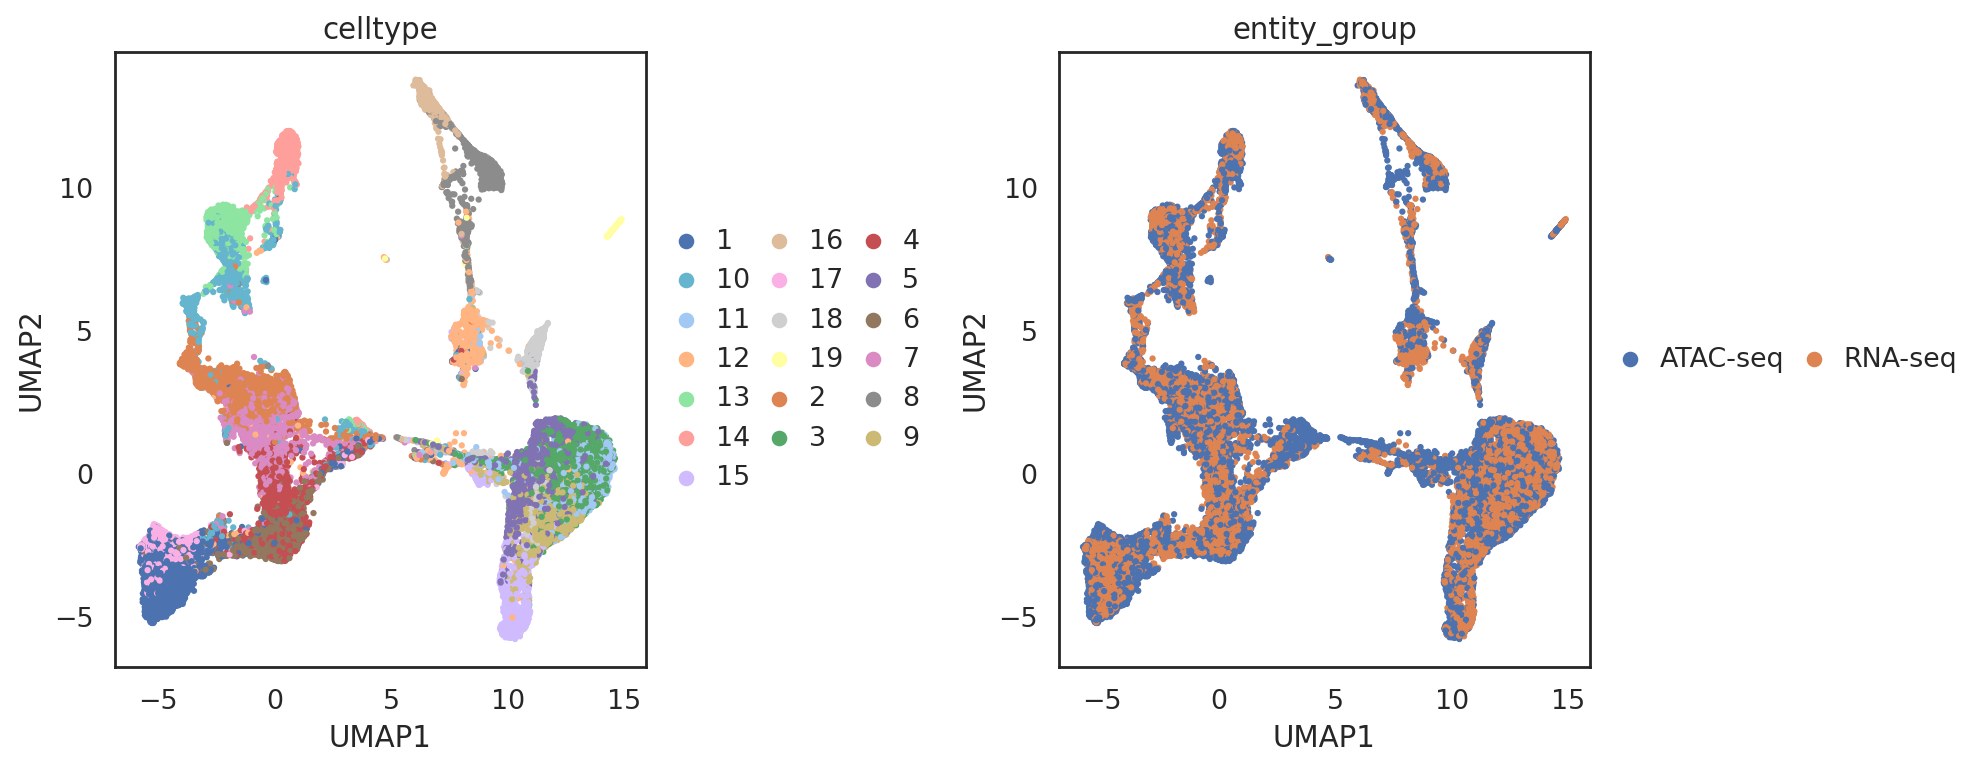

In [61]:
si.pl.umap(adata_all2,
           color=['celltype', 'entity_group'],
           dict_palette={'celltype': palette_celltype},
           drawing_order='random',
           fig_size=(6,5),
           fig_legend_ncol=3)

visualize embeddings of cells (both RNA-seq and ATAC-seq), genes, and peaks

In [62]:
adata_all_CGP = si.tl.embed(adata_ref=adata_C2,
                            list_adata_query=[adata_C, adata_G, adata_P],
                            use_precomputed=False)

Performing softmax transformation for query data 0;
Performing softmax transformation for query data 1;
Performing softmax transformation for query data 2;


In [63]:
# add annotations for all entities
adata_all_CGP.obs['entity_anno'] = ""
adata_all_CGP.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all_CGP.obs.loc[adata_C.obs_names, 'celltype'].tolist()
adata_all_CGP.obs.loc[adata_C2.obs_names, 'entity_anno'] = adata_all_CGP.obs.loc[adata_C2.obs_names, 'celltype'].tolist()
adata_all_CGP.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'
adata_all_CGP.obs.loc[adata_P.obs_names, 'entity_anno'] = 'peak'

In [64]:
# select cell-type specific peaks
adata_cmp_CP = si.tl.compare_entities(adata_ref=adata_C2, adata_query=adata_P)
peaks_selected = adata_cmp_CP.var_names[(adata_cmp_CP.var['max']>1.5) & (adata_cmp_CP.var['gini']>0.35)].tolist()
len(peaks_selected)

19605

In [65]:
# keep only cell-type specific peaks
adata_all_CGP_sub = adata_all_CGP[adata_C.obs_names.tolist() + 
                                  adata_C2.obs_names.tolist() +
                                  adata_G.obs_names.tolist() + 
                                  peaks_selected, :].copy()

In [66]:
si.tl.umap(adata_all_CGP_sub,n_neighbors=15,n_components=2)

In [67]:
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "#607e95"
palette_entity_anno['peak'] = "#e5c2c8"

Trying to set attribute `.uns` of view, copying.


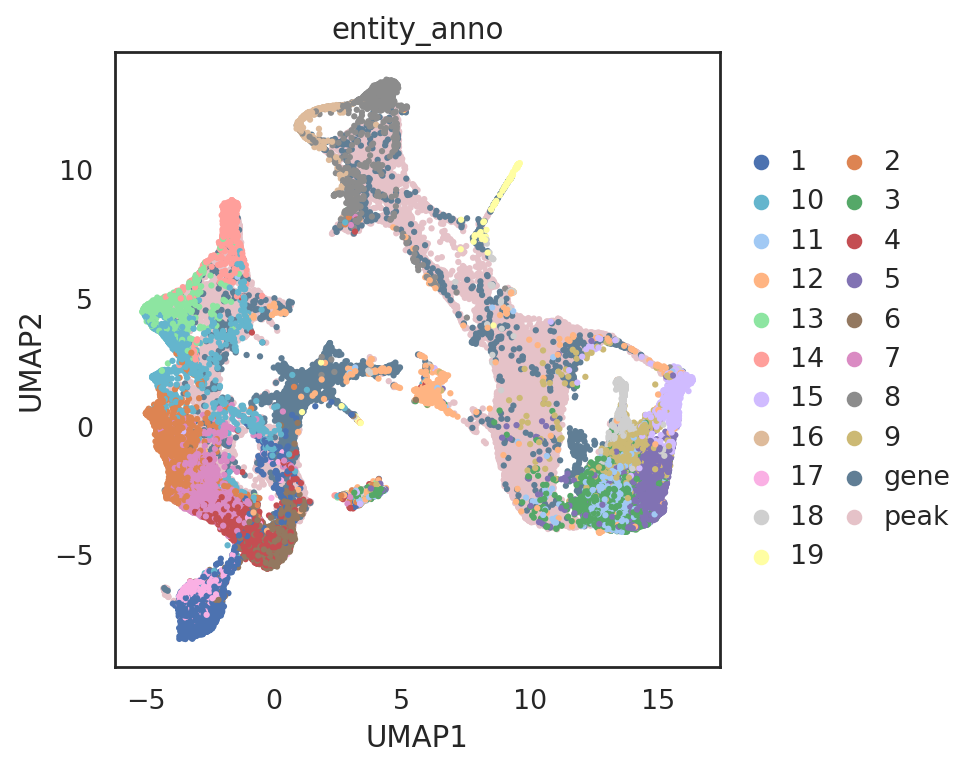

In [68]:
si.pl.umap(adata_all_CGP_sub[::-1,],
           color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           fig_legend_ncol=2,
           fig_size=(6,5))

In [69]:
# find neighbor genes of given pins
query_genes = si.tl.query(adata_all_CGP_sub,
                          pin=np.array([[0.2, -8],[15.0, 2.0]]),
                          use_radius=False,
                          k=5,
                          obsm='X_umap',
                          anno_filter='entity_anno',
                          filters=['gene'])
print(query_genes.shape)
query_genes.head()

(10, 5)


,celltype,id_dataset,entity_anno,distance,query
CEBPA,NaN,query_1,gene,0.374522,1
CSF1R,NaN,query_1,gene,0.392539,1
MAFB,NaN,query_1,gene,0.405876,1
NEURL1,NaN,query_1,gene,0.408441,1
ZNF703,NaN,query_1,gene,0.411102,1


In [88]:
query_genes

,celltype,id_dataset,entity_anno,distance,query
CEBPA,NaN,query_1,gene,0.374522,1
CSF1R,NaN,query_1,gene,0.392539,1
MAFB,NaN,query_1,gene,0.405876,1
NEURL1,NaN,query_1,gene,0.408441,1
ZNF703,NaN,query_1,gene,0.411102,1
NPAS2,NaN,query_1,gene,2.478886,0
LRRC7,NaN,query_1,gene,2.606058,0
SLC16A10,NaN,query_1,gene,2.627616,0
SLC7A8,NaN,query_1,gene,2.744242,0
AL163932.1,NaN,query_1,gene,2.798512,0


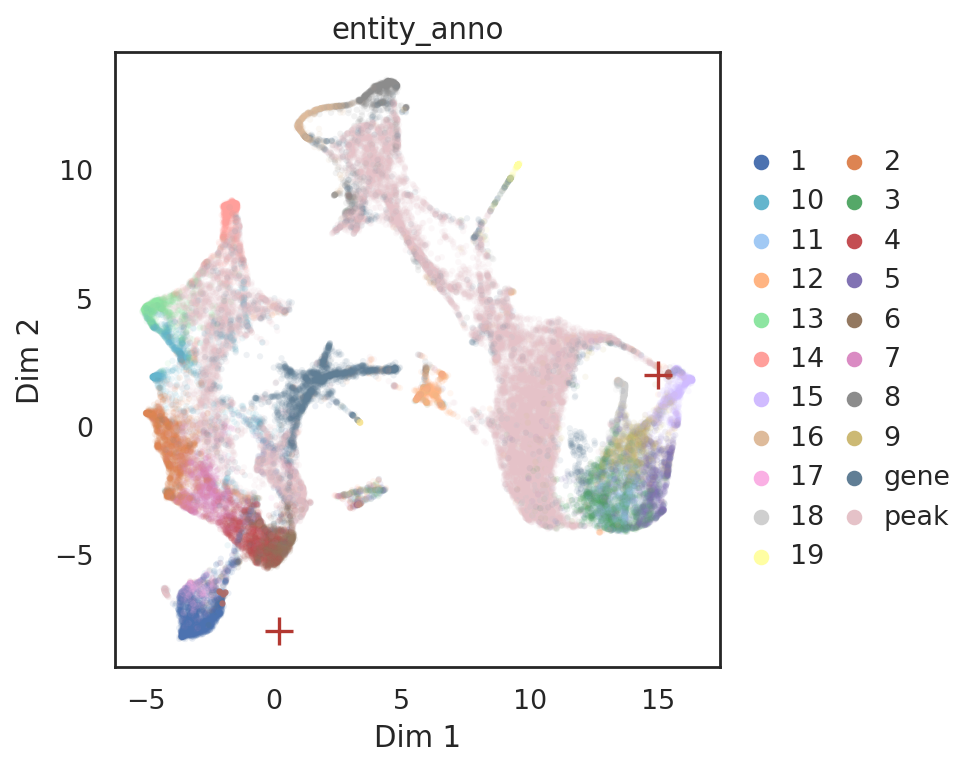

In [70]:
# show locations of pin points and its neighbor genes 
si.pl.query(adata_all_CGP_sub,
            show_texts=False, 
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            alpha=0.9,
            alpha_bg=0.1,
            fig_legend_ncol=2,
            fig_size=(6,5))

In [89]:
query_genes.index

Index(['CEBPA', 'CSF1R', 'MAFB', 'NEURL1', 'ZNF703', 'NPAS2', 'LRRC7',
       'SLC16A10', 'SLC7A8', 'AL163932.1'],
      dtype='object')

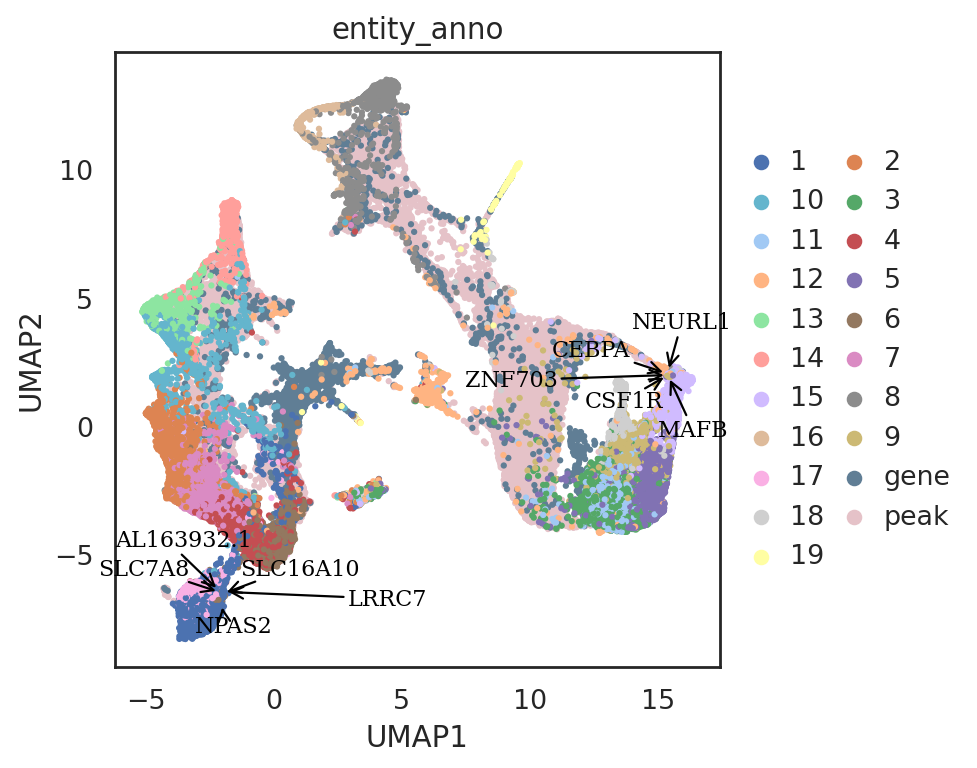

In [71]:
si.pl.umap(adata_all_CGP_sub[::-1],
           color=['entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           show_texts=True,
           texts=query_genes.index,
           text_expand=(1.2,1.4),
           fig_size=(6,5),
           fig_legend_ncol=2)

### save results

In [72]:
adata_CP.write(os.path.join(workdir, 'adata_CP.h5ad'))
adata_CG.write(os.path.join(workdir, 'adata_CG.h5ad'))
adata_CG_atac.write(os.path.join(workdir, 'adata_CG_atac.h5ad'))
adata_CrnaCatac.write(os.path.join(workdir, 'adata_CrnaCatac.h5ad'))

adata_C.write(os.path.join(workdir, 'adata_C.h5ad'))
adata_C2.write(os.path.join(workdir, 'adata_C2.h5ad'))
adata_G.write(os.path.join(workdir, 'adata_G.h5ad'))
adata_P.write(os.path.join(workdir, 'adata_P.h5ad'))

adata_all.write(os.path.join(workdir, 'adata_all.h5ad'))
adata_all2.write(os.path.join(workdir, 'adata_all2.h5ad'))
adata_all_CGP.write(os.path.join(workdir, 'adata_all_CGP.h5ad'))

/PHShome/jr1025/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical
/PHShome/jr1025/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pbg_id' as categorical
/PHShome/jr1025/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering catego

Read back anndata objects

```python
adata_CP = si.read_h5ad(os.path.join(workdir, 'adata_CP.h5ad'))
adata_CG = si.read_h5ad(os.path.join(workdir, 'adata_CG.h5ad'))
adata_CG_atac = si.read_h5ad(os.path.join(workdir, 'adata_CG_atac.h5ad'))
adata_CrnaCatac = si.read_h5ad(os.path.join(workdir, 'adata_CrnaCatac.h5ad'))

adata_C = si.read_h5ad(os.path.join(workdir, 'adata_C.h5ad'))
adata_C2 = si.read_h5ad(os.path.join(workdir, 'adata_C2.h5ad'))
adata_G = si.read_h5ad(os.path.join(workdir, 'adata_G.h5ad'))
adata_P = si.read_h5ad(os.path.join(workdir, 'adata_P.h5ad'))

adata_all = si.read_h5ad(os.path.join(workdir, 'adata_all.h5ad'))
adata_all2 = si.read_h5ad(os.path.join(workdir, 'adata_all2.h5ad'))
adata_all_CGP = si.read_h5ad(os.path.join(workdir, 'adata_all_CGP.h5ad'))
```